# Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

In [4]:
file_path = './data/train-00000-of-00001.parquet'
try:
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path, engine="pyarrow")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
except ValueError as e:
    print(f"Error reading Parquet file: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

# Display first 5 rows
df.head()

,id,Date,Query,IsImplicitIntent,Country,PopularityScore
0,1,2020-09-01,coronavirus worldometer,False,Romania,3
1,2,2020-09-01,scdhec,True,United States,1
2,3,2020-09-01,n95 mask coronavirus,False,United States,1
3,4,2020-09-01,parcelamento fgts mp 927,True,Brazil,28
4,5,2020-09-01,coronavirus colombia,False,United States,1


In [5]:
# check for missing values
df.isna().sum()

id                  0
Date                0
Query               0
IsImplicitIntent    0
Country             0
PopularityScore     0
dtype: int64

In [6]:
# check the data types
df.dtypes

id                   int32
Date                object
Query               object
IsImplicitIntent    object
Country             object
PopularityScore      int32
dtype: object

In [7]:
# convert the "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

id                           int32
Date                datetime64[ns]
Query                       object
IsImplicitIntent            object
Country                     object
PopularityScore              int32
dtype: object

In [8]:
# check the dimensions about the data
df.shape

(317856, 6)

In [9]:
# check the timespan of the dataset
print('Begin date: {}'.format(df['Date'].min()))
print('End date: {}'.format(df['Date'].max())) 

Begin date: 2020-09-01 00:00:00
End date: 2020-09-30 00:00:00


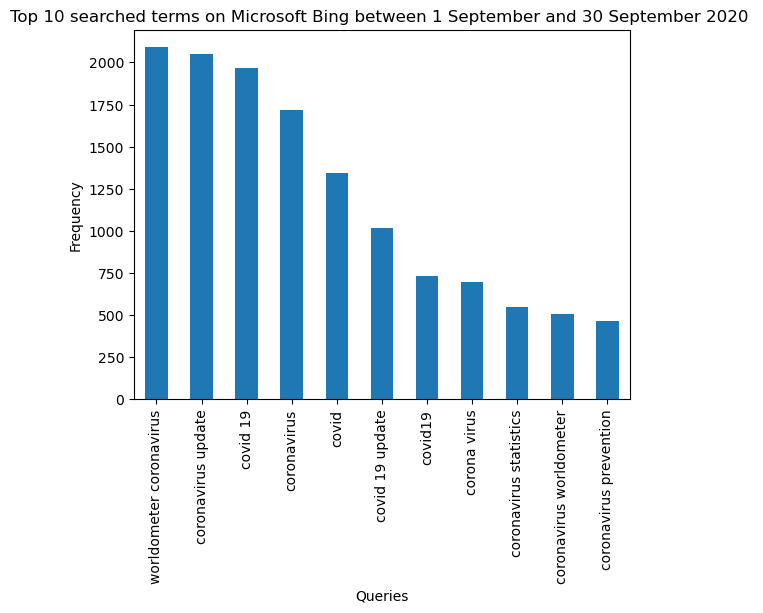

In [10]:
# show the top 10 queries all around the world 
df['Query'].value_counts()[:11].plot(kind='bar')
plt.title('Top 10 searched terms on Microsoft Bing between 1 September and 30 September 2020 ')
plt.ylabel('Frequency')
plt.xlabel('Queries')
plt.show()

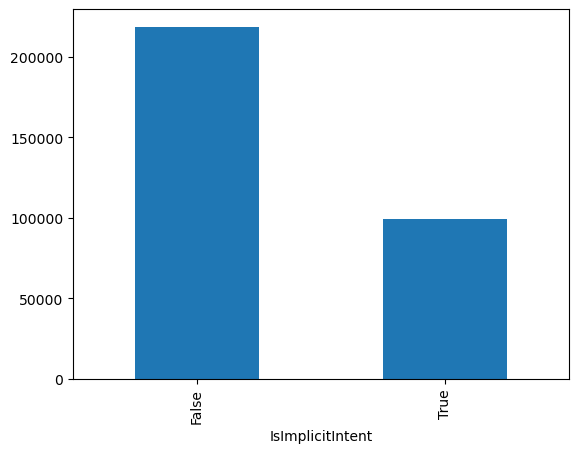

In [11]:
# show the distribution of how specific or generic the queries were
df['IsImplicitIntent'].value_counts().plot(kind='bar')
plt.show()

We can clearly see from the above plot that the dataset is imbalanced. As a result, the model might be good at generalizing coronavirus related queries rather than generic ones.

In [13]:
# remove unnecessary columns
df = df.drop(columns=[
    'id',
    'Query',
    'Country'
], axis=1)

In [14]:
# encoding categorical variables
df['IsImplicitIntent'] = df['IsImplicitIntent'].apply(lambda x: 1 if x == 'True' else 0)
df.head()

,Date,IsImplicitIntent,PopularityScore
0,2020-09-01,0,3
1,2020-09-01,1,1
2,2020-09-01,0,1
3,2020-09-01,1,28
4,2020-09-01,0,1


In [15]:
"""
encoder = OneHotEncoder()
df['Country'] = encoder.fit_transform(
    np.reshape(df['Country'], (-1, 1))
).toarray()
"""

"\nencoder = OneHotEncoder()\ndf['Country'] = encoder.fit_transform(\n    np.reshape(df['Country'], (-1, 1))\n).toarray()\n"

In [16]:
# scaling the numerical variables
scaler = StandardScaler()
df['PopularityScore'] = scaler.fit_transform(
    np.reshape(df['PopularityScore'], (-1, 1))
)

# Feature Engineering

In [18]:
# time based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df.head()

,Date,IsImplicitIntent,PopularityScore,Day,Month
0,2020-09-01,0,-0.047023,1,9
1,2020-09-01,1,-0.217525,1,9
2,2020-09-01,0,-0.217525,1,9
3,2020-09-01,1,2.084259,1,9
4,2020-09-01,0,-0.217525,1,9


In [19]:
# remove the "date" column
df.drop('Date', axis=1, inplace=True)

# Model Training

In [21]:
X = df.drop(columns=['IsImplicitIntent'],axis=1)
y = df['IsImplicitIntent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = LogisticRegression(max_iter=10000, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation

In [24]:
# Accuracy score
acc_score = accuracy_score(y_test, y_pred) * 100
print('Model accuracy score: {}'.format(acc_score))

Model accuracy score: 68.6858994525892


In [25]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81     43680
           1       0.49      0.02      0.04     19892

    accuracy                           0.69     63572
   macro avg       0.59      0.51      0.43     63572
weighted avg       0.63      0.69      0.57     63572



# Hyperparamater Tuning

In [50]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # Regularization strength
    'penalty': ['l1', 'l2'],             # Regularization type
    'solver': ['liblinear', 'saga']      # Solvers that support l1/l2
}

# Initialize the GridSearch object
gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,LogisticRegre...andom_state=0)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [51]:
# Display best parameters and score
print("Best parameters:", gs.best_params_)
print("Best accuracy score:", gs.best_score_)

# Evaluate
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best accuracy score: 0.6881164375249409
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     43680
           1       0.49      0.02      0.04     19892

    accuracy                           0.69     63572
   macro avg       0.59      0.51      0.43     63572
weighted avg       0.63      0.69      0.57     63572

